# Метод главных компонент (PCA)
PCA ищет ортогональные направления максимальной дисперсии данных. Компоненты — собственные векторы ковариационной матрицы $\Sigma=\frac{1}{n}X^\top X$. Первая компонента $w_1$ максимизирует $\mathrm{Var}(Xw_1)$ при условии $||w_1||=1$, далее компоненты ортогональны. Доля объясненной дисперсии для компоненты $j$: $\lambda_j / \sum_k \lambda_k$.


## Используемые библиотеки
Используем `numpy`, `pandas`, `seaborn`, `matplotlib`. Из `sklearn` — `load_digits`, `StandardScaler`, `PCA`.


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [11]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.dpi"] = 120
PRIMARY_COLOR = "#1f77b4"
SECONDARY_COLOR = "#ff7f0e"
HEATMAP_CMAP = "coolwarm"


## Датасет: описание и частичная распечатка
Датасет **Digits** — 1797 изображений рукописных цифр 8×8 пикселей (64 признака). Это типичный пример данных высокой размерности, где PCA особенно полезен: 64 пиксельных признака содержат много шума и избыточной информации. PCA позволяет сжать данные до 2 компонент для визуализации и до ~40 компонент с сохранением >95% дисперсии.


In [12]:
digits = load_digits(as_frame=True)
data = digits.frame
print(f"Размерность: {data.shape}")
data.head()


Размерность: (1797, 65)


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## Предварительная обработка
`StandardScaler` обязателен перед PCA: без него признаки с большей дисперсией доминируют при вычислении собственных векторов ковариационной матрицы. После стандартизации каждый признак вносит одинаковый начальный вклад, и PCA выбирает направления истинной информационной структуры.


In [13]:
features = data.drop(columns=["target"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


## Тепловая карта корреляций
Для наглядности берём первые 12 пиксельных признаков. Соседние пиксели коррелируют (пространственная структура изображения) — именно эти корреляции PCA использует для нахождения главных компонент. Высокая корреляция признаков — признак того, что данные можно сжать без большой потери информации.


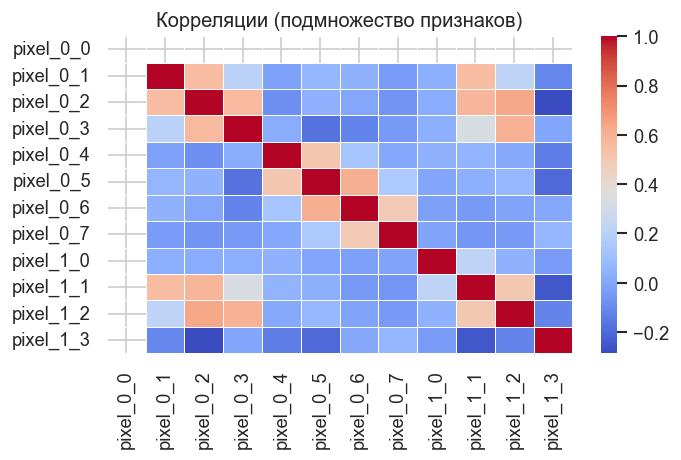

In [14]:
plt.figure(figsize=(6, 4))
subset_cols = features.columns[:12]
correlation = features[subset_cols].corr()
sns.heatmap(correlation, annot=False, cmap=HEATMAP_CMAP, linewidths=0.3)
plt.title("Корреляции (подмножество признаков)")
plt.tight_layout()
plt.show()


## Обучение модели
`PCA(n_components=2)` сводит 64 признака к 2 главным компонентам. Это экстремальное сжатие (потеря информации велика), но достаточно для визуализации. Для практических задач выбирают `n_components` так, чтобы суммарная объяснённая дисперсия была ≥ 95%.


In [15]:
pca = PCA(n_components=2, random_state=42)
pca.fit(X_scaled)


PCA(n_components=2, random_state=42)

## Прогнозы модели
`explained_variance_ratio_` — доля дисперсии, объяснённая каждой компонентой. PC1 и PC2 вместе объясняют обычно 25–35% для Digits (64 признака → 2 компоненты). Для понимания, сколько компонент нужно для 95% дисперсии, строят scree plot по всем компонентам.


In [16]:
X_pca = pca.transform(X_scaled)
explained = pca.explained_variance_ratio_

print("Explained Variance Ratio")
print(f"PC1: {explained[0]:.3f}")
print(f"PC2: {explained[1]:.3f}")


Explained Variance Ratio
PC1: 0.120
PC2: 0.096


## Графики выходных результатов
**График 1. Scree plot (explained variance bar).** Показывает вклад PC1 и PC2. Если бы мы взяли больше компонент, мы бы видели «локоть» — место, где прирост объяснённой дисперсии резко замедляется.

**График 2. 2D-проекция (scatter plot).** Каждая точка — одна цифра, цвет — её класс (0–9). Хорошо разделённые цветовые облака означают, что 2 компоненты несут информацию о различии цифр. Ожидаем, что некоторые цифры (0, 1) будут хорошо изолированы, другие (3, 5, 8) — перекрываться.


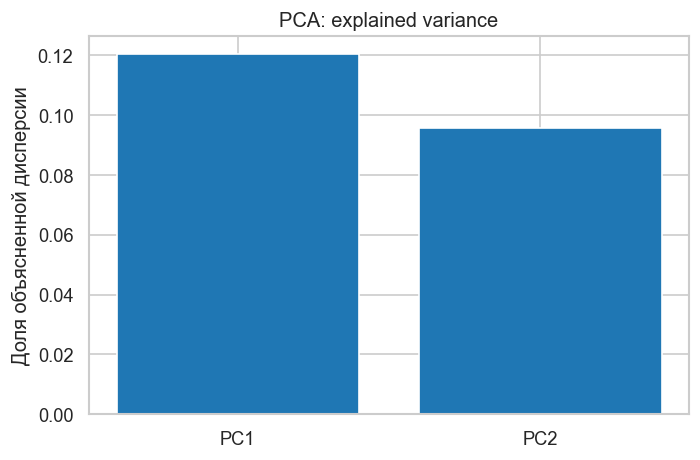

In [17]:
plt.figure(figsize=(6, 4))
plt.bar(["PC1", "PC2"], explained, color=PRIMARY_COLOR)
plt.ylabel("Доля объясненной дисперсии")
plt.title("PCA: explained variance")
plt.tight_layout()
plt.show()


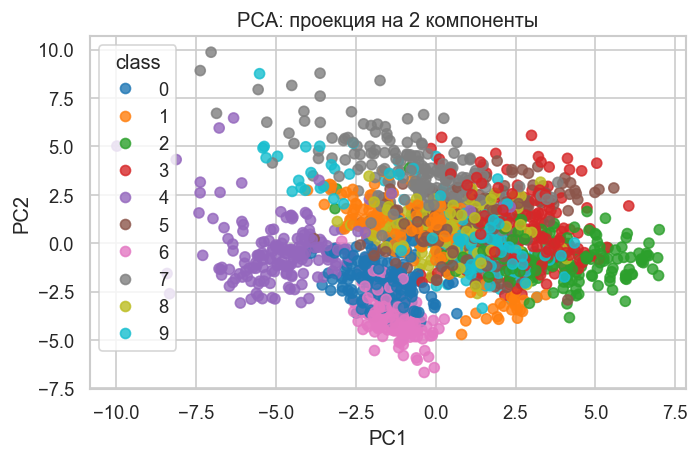

In [18]:
plt.figure(figsize=(6, 4))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=digits.target,
    cmap="tab10",
    alpha=0.8,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: проекция на 2 компоненты")
plt.legend(*scatter.legend_elements(), title="class")
plt.tight_layout()
plt.show()
